# Experiment on the dataset Email EU Core

In [1]:
%load_ext autoreload
%autoreload 2

import sys
if '..' not in sys.path:
    sys.path.append('..')

Import libs

In [88]:
from matplotlib import pyplot as plt
import networkx as nx
import pickle
import contextlib
import numpy as np
import pandas as pd
import itertools
import torch
from math import exp
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset
from tsvar.models import WoldModelVariational
from gb import GrangerBusca

# Set cells width for nicer output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

The dataset must first be downloaded from the SNAP dataset repository: <https://snap.stanford.edu/data/email-Eu-core-temporal.html>

    wget https://snap.stanford.edu/data/email-Eu-core-temporal.txt.gz

Set input path where the dataset is located

In [76]:
INPUT_PATH = "../../data/wiki-talk-temporal.txt.gz"

Load the dataset

In [93]:
dataset = Dataset(INPUT_PATH, top=100, timescale=1.0)

Quick exploration 

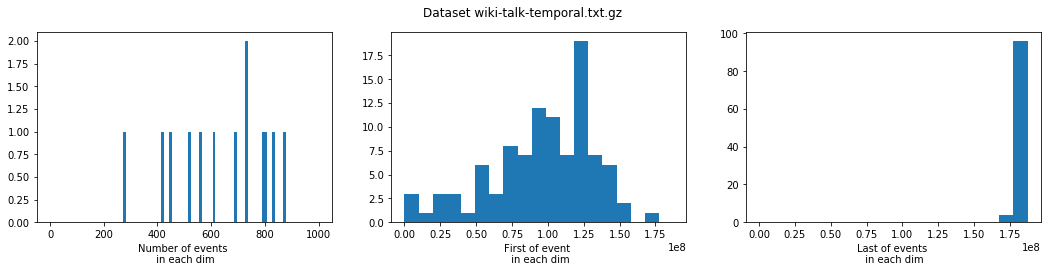

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, dataset.timestamps)), bins=np.linspace(0, 1000, 100))
axs[0].set_xlabel('Number of events \n in each dim')

end_time = dataset.end_time
axs[1].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')

axs[2].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}");

Print statistics of the dataset

In [95]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 211,344
               %NZ: 43.77%

Stats. of num. of events per dim:
count      100.00000
mean      2113.44000
std       3117.16993
min        281.00000
25%       1262.50000
50%       1608.50000
75%       2217.25000
max      31539.00000
dtype: float64


(global) Inter-event time distribution 

In [120]:
median_inter_event_time = np.median(np.diff(sorted(np.hstack(dataset.timestamps))))
time_scale = median_inter_event_time / exp(1)
all_events = [ev / time_scale for ev in dataset.timestamps]

dataset.time_scale = np.nan
dataset.timestamps = all_events

Build ground truth adjacency matrix

In [121]:
adjacency_true = nx.adjacency_matrix(dataset.graph, nodelist=range(dataset.dim)).toarray()
adjacency_true = adjacency_true / adjacency_true.max()

In [142]:
events = dataset.timestamps
events = [np.sort(ev) for ev in events]
end_time = dataset.end_time

t0 = min(map(min, events))
t1 = max(map(max, events))

train_start = t0
train_end = t0 + (t1 - t0) * 0.75
test_end = t1 + 1e-5

train_events = [ev[(ev >= train_start) & (ev < train_end)] - train_start for ev in events]
test_events = [ev[(ev >= train_end) & (ev < test_end)] - train_end for ev in events]

print('Number of training events:', sum(map(len, train_events)))
print('Number of test events:', sum(map(len, test_events)))

Number of training events: 80425
Number of test events: 130919


In [138]:
valid_dims = np.array([((len(ev1) > 0), (len(ev2) > 0)) for ev1, ev2 in zip(train_events, test_events)])
#train_events = np.array(train_events)[valid_dims].tolist()
#test_events = np.array(test_events)[valid_dims].tolist()

In [139]:
train_events = np.array(train_events)[valid_dims[:,0]].tolist()
test_events = np.array(test_events)[valid_dims[:,0]].tolist()

In [140]:
len(train_events), len(test_events)

(93, 93)

Set the test model to compute the predictive log-likelihood

In [51]:
# Remove dimensions with no observation in the test set or in the train set
test_dims = np.array([len(ev) > 0 for ev in test_events])
num_test_events = sum(map(len, test_events))
test_events_filtered = np.array(test_events)[test_dims].tolist()
# Feed test observations to the model
test_model = tsvar.models.WoldModel()
test_model.observe(test_events_filtered)

---

## Run inference


### Run VI

In [68]:
dim = len(train_events)

# Set priors
# prior: Alpha
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 10.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 1.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(train_events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr[0,0] / ar_pr[0,0])
print('variance')
print(as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance')
print(br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
mean
0.1
variance
0.01
BETA:
-----
mean
0.1111111111111111
variance
0.0015432098765432098


In [69]:
# Set model & observations
vi_model = WoldModelVariational(verbose=True)
vi_model.observe(train_events)

In [70]:
# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
             max_iter=100, tol=1e-4, callback=None)

a_mean: min:+2.09e-04, max:+3.81e+00
Beta optim failed for xn, switch to bin search
Beta optim failed for xn, switch to bin search
b_mean: min:-0.00e+00, max:+1.86e+01


RuntimeError: Optimization results of beta update is negative!

In [ ]:
vals = list()
adj_list = list()
for i in range(10):
    as_po = vi_model._as_po[np.hstack([[True], test_dims]), :][:, test_dims]
    ar_po = vi_model._ar_po[np.hstack([[True], test_dims]), :][:, test_dims]
    bs_po = vi_model._bs_po[test_dims, :][:, test_dims]
    br_po = vi_model._br_po[test_dims, :][:, test_dims]

    alpha_sample = np.random.gamma(shape=as_po, scale=1/ar_po)
    beta_sample = np.random.gamma(shape=bs_po, scale=1/br_po)
    coeffs = torch.tensor(np.hstack((
        alpha_sample[0, :].flatten(), beta_sample.flatten(), alpha_sample[1:, :].flatten()
    )))
    ll = test_model.log_likelihood(coeffs) / num_test_events
    vals.append(ll)
    adj_list.append(np.random.gamma(shape=vi_model._as_po, scale=1/vi_model._ar_po)[1:, :])
print(f"Predictive log-likelihood: {np.mean(vals):.2f} ($\pm {np.std(vals):.2e}$)")


### Run GB

In [46]:
vals = list()
for i in range(10):
    print(f'\r{i}', end='')
    # Define model
    granger_model = GrangerBusca(
        alpha_prior=10.00,
        num_iter=3000,
        metropolis=True,
        beta_strategy='busca',
        num_jobs=2,
    )

    # Fit the model
    granger_model.fit(train_events)

    # Extract estimate of parameters
    mu_hat = granger_model.mu_[test_dims]
    adj_hat = granger_model.Alpha_.toarray()[test_dims, :][:, test_dims]
    adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
    beta_hat = np.ones((len(train_events), len(train_events))) * granger_model.beta_
    beta_hat = beta_hat[test_dims, :][:, test_dims]
    coeffs_hat = torch.tensor(np.hstack((
        mu_hat, beta_hat.flatten(), adj_hat.flatten()
    )))

    ll = test_model.log_likelihood(coeffs_hat) / num_test_events
    vals.append(ll)
print(f"\nPredictive log-likelihood: {np.mean(vals):.2f} ($\pm {np.std(vals):.2e}$)")

9

FloatingPointError: invalid value encountered in subtract

In [59]:
coeffs_hat = torch.tensor(np.hstack((
        mu_hat+1e-10, beta_hat.flatten(), adj_hat.flatten()
    )))

ll = test_model.log_likelihood(coeffs_hat) / num_test_events

ll

tensor(-1.7185, dtype=torch.float64)

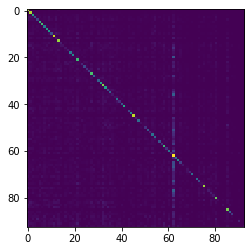

In [60]:
plt.imshow(adj_hat)